Import Libraries & set visualization style

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set visualization style
sns.set(style="whitegrid")


Upload the file

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving shopee-products.csv to shopee-products.csv


In [ ]:
import os
os.listdir("/content")


['.config', 'shopee-products.csv', 'sample_data']

Add required column

In [ ]:
# Load Shopee Dataset
uploaded_path = "/content/shopee-products.csv"
shopee_df = pd.read_csv(uploaded_path)


#Generate Synthetic Order Fulfillment Data
np.random.seed(42)
n_orders = shopee_df.shape[0]
statuses = np.random.choice(['Delivered', 'Failed', 'Returned'], size=n_orders, p=[0.75, 0.15, 0.10])
start_date = datetime.today() - timedelta(days=90)
order_dates = [start_date + timedelta(days=np.random.randint(0, 90)) for _ in range(n_orders)]
delivery_dates = [
    order_date + timedelta(days=np.random.randint(2, 10)) if status == 'Delivered' else None
    for order_date, status in zip(order_dates, statuses)
]
order_ids = np.arange(1, n_orders + 1)

# Add new columns
shopee_df['order_id'] = order_ids
shopee_df['status'] = statuses
shopee_df['order_date'] = order_dates
shopee_df['delivery_date'] = delivery_dates
shopee_df['delivery_time'] = (shopee_df['delivery_date'] - shopee_df['order_date']).dt.days


In [ ]:
#Create SQLite DB for SQL Analysis
orders_df = shopee_df[['order_id', 'status', 'order_date', 'delivery_date', 'delivery_time']]
conn = sqlite3.connect(":memory:")
orders_df.to_sql("orders", conn, index=False, if_exists='replace')


1000

In [ ]:
# SQL KPIs

# On-time Delivery Rate
query_1 = """
SELECT ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM orders), 2) AS on_time_delivery_rate
FROM orders
WHERE status = 'Delivered';
"""

# Average Delivery Time
query_2 = """
SELECT ROUND(AVG(julianday(delivery_date) - julianday(order_date)), 2) AS avg_delivery_time
FROM orders
WHERE status = 'Delivered';
"""

# Failed Delivery Rate
query_3 = """
SELECT ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM orders), 2) AS failed_delivery_rate
FROM orders
WHERE status = 'Failed';
"""

# Run queries
on_time_df = pd.read_sql_query(query_1, conn)
avg_delivery_df = pd.read_sql_query(query_2, conn)
failed_rate_df = pd.read_sql_query(query_3, conn)

# Show Results
display(on_time_df)
display(avg_delivery_df)
display(failed_rate_df)


,on_time_delivery_rate
0,75.7


,avg_delivery_time
0,5.58


,failed_delivery_rate
0,14.3


<ipython-input-24-3128925602>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders_df, x='status', palette='Set2')


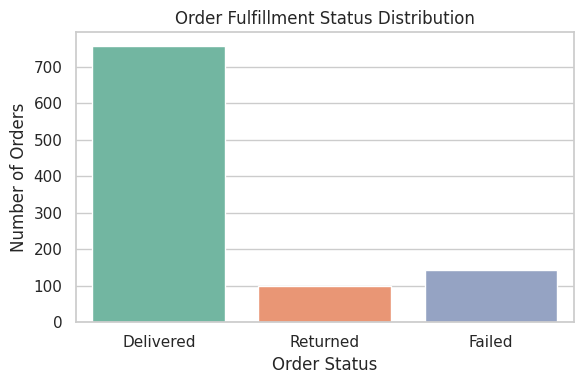

In [ ]:
# Visualization - Order Status Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=orders_df, x='status', palette='Set2')
plt.title("Order Fulfillment Status Distribution")
plt.xlabel("Order Status")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


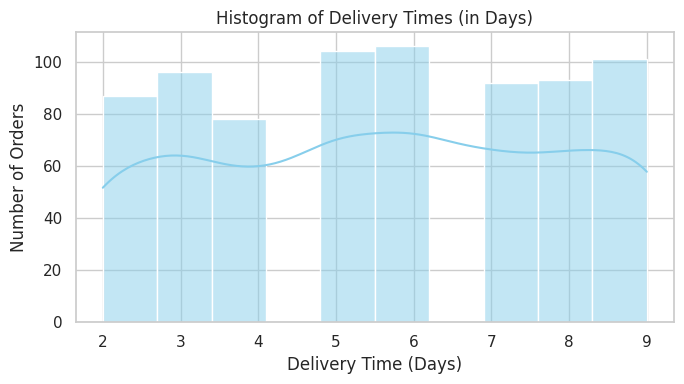

In [ ]:
#Histogram of Delivery Times (Only Delivered)
delivered_df = orders_df[orders_df['status'] == 'Delivered']
plt.figure(figsize=(7, 4))
sns.histplot(delivered_df['delivery_time'], bins=10, kde=True, color="skyblue")
plt.title("Histogram of Delivery Times (in Days)")
plt.xlabel("Delivery Time (Days)")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


<ipython-input-20-1113612994>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_df['week'] = delivered_df['delivery_date'].dt.to_period('W').dt.start_time


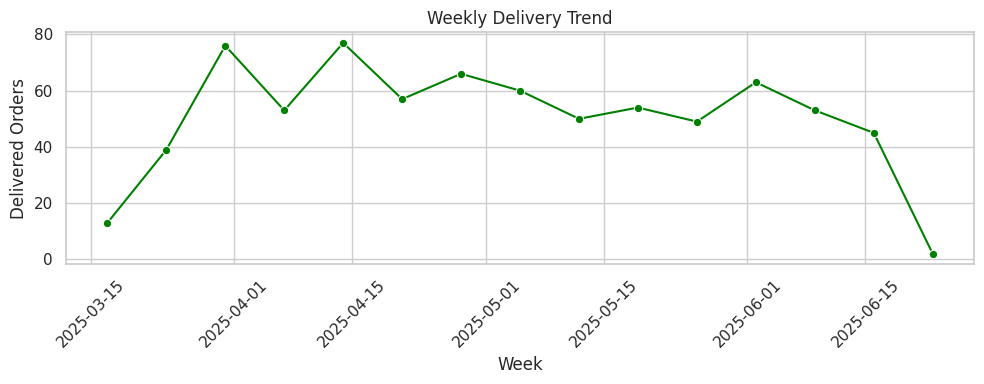

In [ ]:
#Weekly Trend of Deliveries
delivered_df['week'] = delivered_df['delivery_date'].dt.to_period('W').dt.start_time
weekly_deliveries = delivered_df.groupby('week').size().reset_index(name='num_delivered')

plt.figure(figsize=(10, 4))
sns.lineplot(data=weekly_deliveries, x='week', y='num_delivered', marker='o', color='green')
plt.title("Weekly Delivery Trend")
plt.xlabel("Week")
plt.ylabel("Delivered Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
